<a href="https://colab.research.google.com/github/MasoudMoeini/Google-Street-View-Images-Blur-Detection/blob/main/SBDN_Catt_CAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model,load_model
from keras.optimizers import gradient_descent_v2 
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense,Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras import regularizers

In [2]:
!unzip -qq images.zip

replace images/0-4695.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [9]:
!unzip -qq labels.zip

In [2]:
from PIL import Image,ImageOps
from numpy import *
images_folder= "images/*.jpg"
labels_folder = "labels/"
def data_preprocessing(images_folder,labels_folder):
  total_img = []
  class_label=[]
  label = []
  files = glob.glob (images_folder)
  for myFile in files[:5000]:
      image_name=os.path.split(myFile)[1]
      class_label.append(float(image_name[0]))
      image = array(Image.open(myFile))
      label_image = array(Image.open(labels_folder+image_name))
      label.append (label_image)
      total_img.append (image)
  total_img = np.array(total_img)
  label = np.array(label)
  class_label=np.array(class_label) 
  label= np.reshape(label,[label.shape[0],label.shape[1],label.shape[2],label.shape[3]])
  total_img= np.reshape(total_img,[total_img.shape[0],total_img.shape[1],total_img.shape[2],total_img.shape[3]])
  return class_label,label,total_img

In [3]:
class_labels,total_labels,total_images=data_preprocessing(images_folder,labels_folder)

In [18]:
total_images.shape

(5000, 224, 224, 3)

In [19]:
total_labels.shape

(5000, 224, 224, 3)

In [20]:
class_labels.shape

(5000,)

In [4]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [5]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [6]:
def decoder_network(HLSF):
    # 7*7*2048 is input tensor 
    #decoder 
    dec2 = layers.Conv2DTranspose(2048, (3, 3), strides=2, activation="relu", padding="same")(HLSF) #14*14*2048
    dec3 = layers.Conv2DTranspose(512, (3, 3), strides=2, activation="relu", padding="same")(dec2)#28*28*512
    dec4 = layers.Conv2DTranspose(128, (3, 3), strides=2, activation="relu", padding="same")(dec3)#56*56*128
    dec5 = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(dec4)#112*112*32
    dec6 = layers.Conv2DTranspose(3, (3, 3), strides=2, activation="relu", padding="same")(dec5)#224*224*3
    dec7 = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid",padding="same")(dec6)#224*224*1
    dec8 = layers.Conv2DTranspose(3, (3, 3), strides=1, activation="sigmoid",padding="same",name='DecBM')(dec7)#224*224*1
    #FusionNetwork1
    Upsam_Deep1 = layers.Conv2DTranspose(128, (3, 3), strides=32, activation="relu", padding="same")(HLSF)
    Upsam_Deep2 = layers.Conv2DTranspose(128, (3, 3), strides=16, activation="relu", padding="same")(dec2)
    Upsam_Deep3 = layers.Conv2DTranspose(128, (3, 3), strides=8, activation="relu", padding="same")(dec3)
    concatted_deep = tf.keras.layers.Concatenate(axis=3)([Upsam_Deep1,Upsam_Deep2,Upsam_Deep3])
    result_concatted_deep= layers.Conv2D(1, (1, 1), strides=1, activation="sigmoid", padding="same",name='HLBM')(concatted_deep) #224*224*1
    #FusionNetwork2
    Upsam_Shallow1=layers.Conv2DTranspose(16, (3, 3), strides=4, activation="relu", padding="same")(dec4)
    Upsam_Shallow2=layers.Conv2DTranspose(16, (3, 3), strides=2, activation="relu", padding="same")(dec5)
    concatted_Shallow = tf.keras.layers.Concatenate()([Upsam_Shallow1,Upsam_Shallow2,dec6])
    result_concatted_Shallow= layers.Conv2D(1, (1, 1), strides=1, activation="sigmoid", padding="same",name='LLBM')(concatted_Shallow) #224*224*1
    #Concatenate all results
    concatted_all = tf.keras.layers.Concatenate()([dec7,result_concatted_deep,result_concatted_Shallow])
    final_output= layers.Conv2D(3, (1, 1), strides=1, activation="sigmoid", padding="same",name='FBME')(concatted_all) #224*224*1
    return final_output

In [7]:
def ResNet50():
    X_input = Input(shape=(224, 224, 3))
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    HLSF = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')
    #7*7*2048
    #identification
    main=decoder_network(HLSF)
    #Classification
    X = AveragePooling2D(pool_size=(2, 2), padding='same')(HLSF)
    X = Flatten()(X)
    X = Dense(512, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(X)
    X = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(X)
    output1 = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(X)
    
    model = Model(inputs=X_input, outputs=[main,output1], name='ResNet50')
    return model

In [ ]:
model= ResNet50()
#keras.utils.plot_model(model, show_shapes=True)
#model.summary()

In [10]:
class_label=class_labels[:1500]
x_train = total_images[:1500].astype(np.float32)/ 255.0
y_train=total_labels[:1500].astype(np.float32)/ 255.0
y_train = (y_train,class_label)

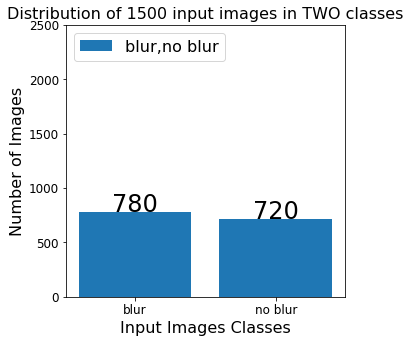

In [11]:
unique, counts = np.unique(class_label, return_counts=True)
import matplotlib.pyplot as plt
def addlabels(x,y):
	for i in range(len(x)):
		plt.text(i,y[i],y[i],fontsize=24, ha='center')
if __name__ == '__main__':
	# creating data on which bar chart will be plot
	x = ['blur','no blur']
	y = [counts[0],counts[1]]
plt.figure(figsize=(5,5))
plt.bar(x, y,label='blur,no blur')
addlabels(x, y)
plt.title(f"Distribution of {(class_label.shape)[0]} input images in TWO classes",fontsize=16)
plt.xlabel('Input Images Classes',fontsize=16)
plt.ylabel('Number of Images',fontsize=16)
plt.yticks(np.arange(0, 3000,500),fontsize=12)
plt.xticks(fontsize=12)
plt.gca().legend(prop={'size': 16},loc='upper left',fontsize=14)
plt.show()

In [12]:
class StopOnPoint(tf.keras.callbacks.Callback):
    def __init__(self, point):
        super(StopOnPoint, self).__init__()
        self.point = point
    def on_epoch_end(self, epoch, logs=None): 
        loss = logs["fc3_loss"]
        if loss <= self.point:
            self.model.stop_training = True
callbacks = [StopOnPoint(0.01)]

In [17]:
loss1= tf.keras.losses.MeanSquaredError()
loss2= tf.keras.losses.BinaryCrossentropy()
#learning rate control is very important*****
model.compile(keras.optimizers.Adam(learning_rate=0.00006),loss = [loss1,loss2])

In [18]:
history = model.fit(x_train,[y_train[0],y_train[1]], epochs=100,batch_size=20, validation_split=0.2,shuffle=True,callbacks=[callbacks])
model.save('sbdn_cam_model.h5')

Epoch 1/100
60/60 [==============================] - 57s 853ms/step - loss: 0.9574 - FBME_loss: 0.1507 - fc3_loss: 0.8067 - val_loss: 1.0008 - val_FBME_loss: 0.1478 - val_fc3_loss: 0.8529
Epoch 2/100
60/60 [==============================] - 49s 821ms/step - loss: 0.6675 - FBME_loss: 0.1476 - fc3_loss: 0.5199 - val_loss: 1.7491 - val_FBME_loss: 0.1444 - val_fc3_loss: 1.6047
Epoch 3/100
60/60 [==============================] - 50s 827ms/step - loss: 0.5207 - FBME_loss: 0.1444 - fc3_loss: 0.3763 - val_loss: 0.8263 - val_FBME_loss: 0.1415 - val_fc3_loss: 0.6848
Epoch 4/100
60/60 [==============================] - 49s 824ms/step - loss: 0.4083 - FBME_loss: 0.1415 - fc3_loss: 0.2668 - val_loss: 0.5911 - val_FBME_loss: 0.1383 - val_fc3_loss: 0.4528
Epoch 5/100
60/60 [==============================] - 49s 825ms/step - loss: 0.3898 - FBME_loss: 0.1385 - fc3_loss: 0.2512 - val_loss: 1.7210 - val_FBME_loss: 0.1355 - val_fc3_loss: 1.5855
Epoch 6/100
60/60 [==============================] - 49s 824

In [16]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'FBME_loss', 'fc3_loss', 'val_loss', 'val_FBME_loss', 'val_fc3_loss'])


In [23]:
import pandas as pd
hist_df = pd.DataFrame(history.history)
hist_csv_file = 'sbdn-cam-history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

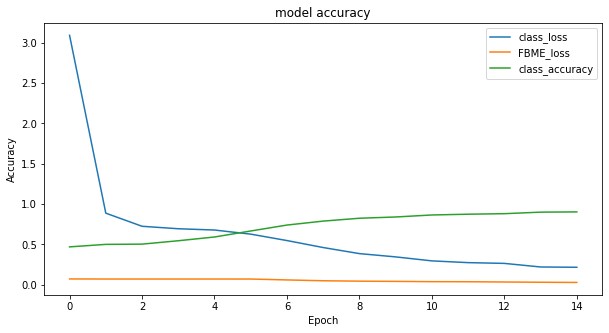

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(history.history['class_loss'])
plt.plot(history.history['FBME_loss'])
plt.plot(history.history["class_accuracy"])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["class_loss",'FBME_loss','class_accuracy'])
plt.show()

In [18]:
eval_images=total_images[2000:2500]
eval_labels=total_labels[2000:2500]
eval_class_label=class_labels[2000:2500]

In [ ]:
from keras.models import load_model
from keras import backend as K
import scipy
from PIL import Image
model = load_model("sbdn_cam_model.h5")
keras.utils.plot_model(model, show_shapes=True)
images = eval_images
predictions=[]
for i in range(images.shape[0]):
  img = images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  pred = model.predict(img)
  predictions.append(pred)

In [43]:
(((predictions[0])[0])[0]).shape

(224, 224, 3)

In [46]:
(((predictions[0])[1])[0])[0]

0.99905545

In [47]:
def get_class_activation_map(model, img):
    ''' 
    this function computes the class activation map
    
    Inputs:
        1) model (tensorflow model) : trained model
        2) img (numpy array of shape (224, 224, 3)) : input image
    '''
    # predict to get the winning class
    predictions = model.predict(img)
    predictions=(predictions[1])[0]
    label_index = np.argmax(predictions)
    
    # Get the 2048 input weights to the softmax of the winning class.
    class_weights = model.layers[-1].get_weights()[0]
    class_weights_winner = class_weights[:, label_index]
    
    # get the final conv layer
    final_conv_layer = model.get_layer('activation_97')
    #model'activation_48'
    # create a function to fetch the final conv layer output maps (should be shape (1, 7, 7, 2048)) 
    get_output = K.function([model.layers[0].input],[final_conv_layer.output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img])
    
    # squeeze conv map to shape image to size (7, 7, 2048)
    conv_outputs = np.squeeze(conv_outputs)
    
    # bilinear upsampling to resize each filtered image to size of original image 
    mat_for_mult = scipy.ndimage.zoom(conv_outputs, (32, 32, 1), order=1) # dim: 224 x 224 x 2048

    # get class activation map for object class that is predicted to be in the image
    mm=scipy.ndimage.zoom(class_weights, (16,1), order=1)
    final_output = np.dot(mat_for_mult.reshape(224*224, 2048), mm).reshape(224,224) # dim: 224 x 224
    
    # return class activation map
    return final_output

In [ ]:
model = load_model("sbdn_cam_model.h5")
keras.utils.plot_model(model, show_shapes=True)

In [20]:
class_activation_map=[]
selected_images=images[:20]
for i in range(selected_images.shape[0]):
  img = selected_images[i]
  img = img.astype(np.float32)/ 255.0
  img = np.expand_dims(img, -1)
  img = np.expand_dims(img, 0)
  ss=get_class_activation_map(model, img)
  class_activation_map.append(ss)

NameError: ignored

In [21]:
ground_truth_total=eval_labels/255.0
def get_iou_score(true_label, y_pred_label):
  iou_scores=[]
  for i in range(0,len(true_label)):
    #true_label = eval_labels[i]/255.0
    pp=np.where(((predictions[i])[0])[0]>0.5,1.0,0.0)
    pp=reshape(pp,[224,224,3])
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(true_label[i],pp)
    iou_scores.append(m.result().numpy())
  return mean(iou_scores)
iou_score= get_iou_score(ground_truth_total,predictions)
print('Average Intersection over Union IoU for Blur Detection: ',iou_score )

Average Intersection over Union IoU for Blur Detection:  0.4063739


# Confusion Matrix

In [22]:
y_pred_class=[]
for i in range(len(predictions)):
  predicted_class=(((predictions[i])[1])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  y_pred_class.append(predicted_class)
y_pred_class=np.array(y_pred_class)

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
conf_m = confusion_matrix(eval_class_label, y_pred_class)
conf_m

array([[226,  24],
       [ 21, 229]])

In [24]:
report = classification_report(eval_class_label, y_pred_class)
print(report)

              precision    recall  f1-score   support

         0.0       0.91      0.90      0.91       250
         1.0       0.91      0.92      0.91       250

    accuracy                           0.91       500
   macro avg       0.91      0.91      0.91       500
weighted avg       0.91      0.91      0.91       500



predicted class vs true class


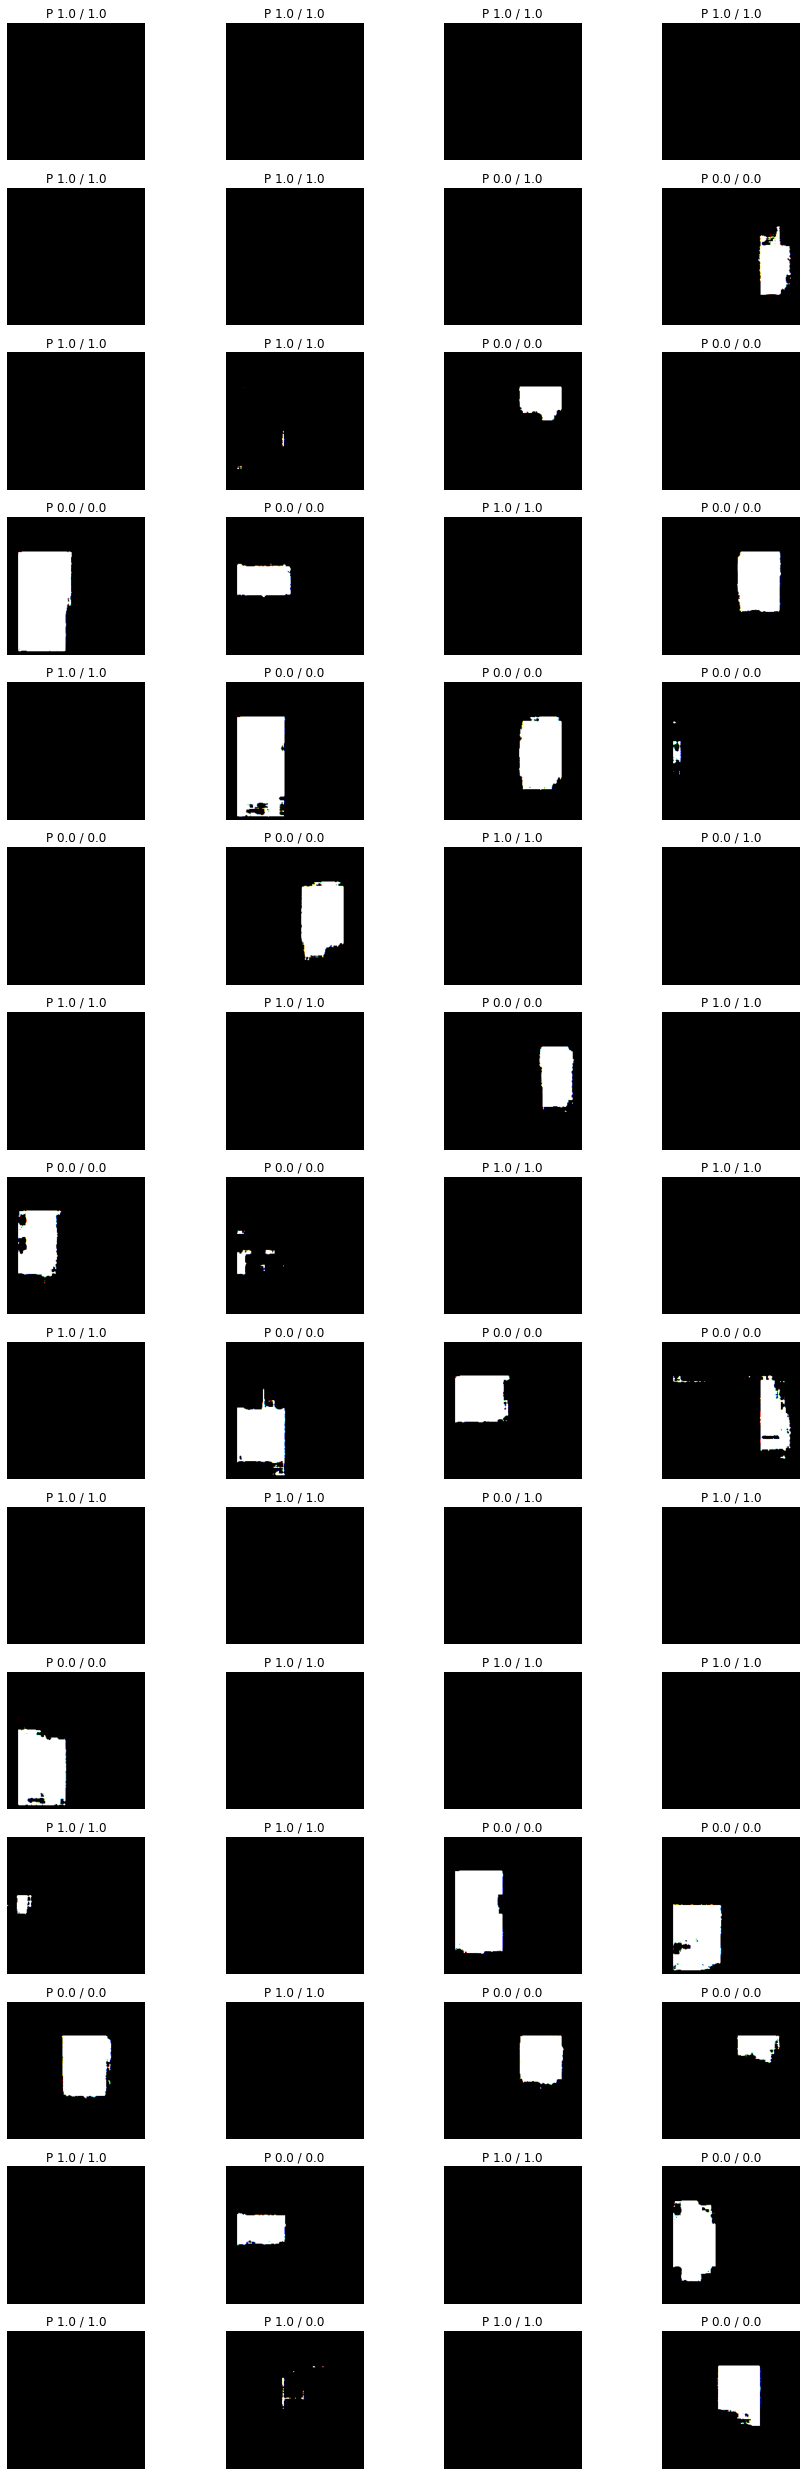

In [45]:
columns = 4
rows = 15
print("predicted class vs true class")
fig = plt.figure(figsize=(15,45))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[0])[0])>0.5,1.0,0.0)
  plt.imshow((img_pred_label*255.0).astype(np.uint8))
  predicted_class=(((predictions[i])[1])[0])[0]
  if (predicted_class>0.5):
    predicted_class=1.0
  else:
    predicted_class=0.0
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=12)
  plt.axis("off")
plt.show()

predicted class vs true class


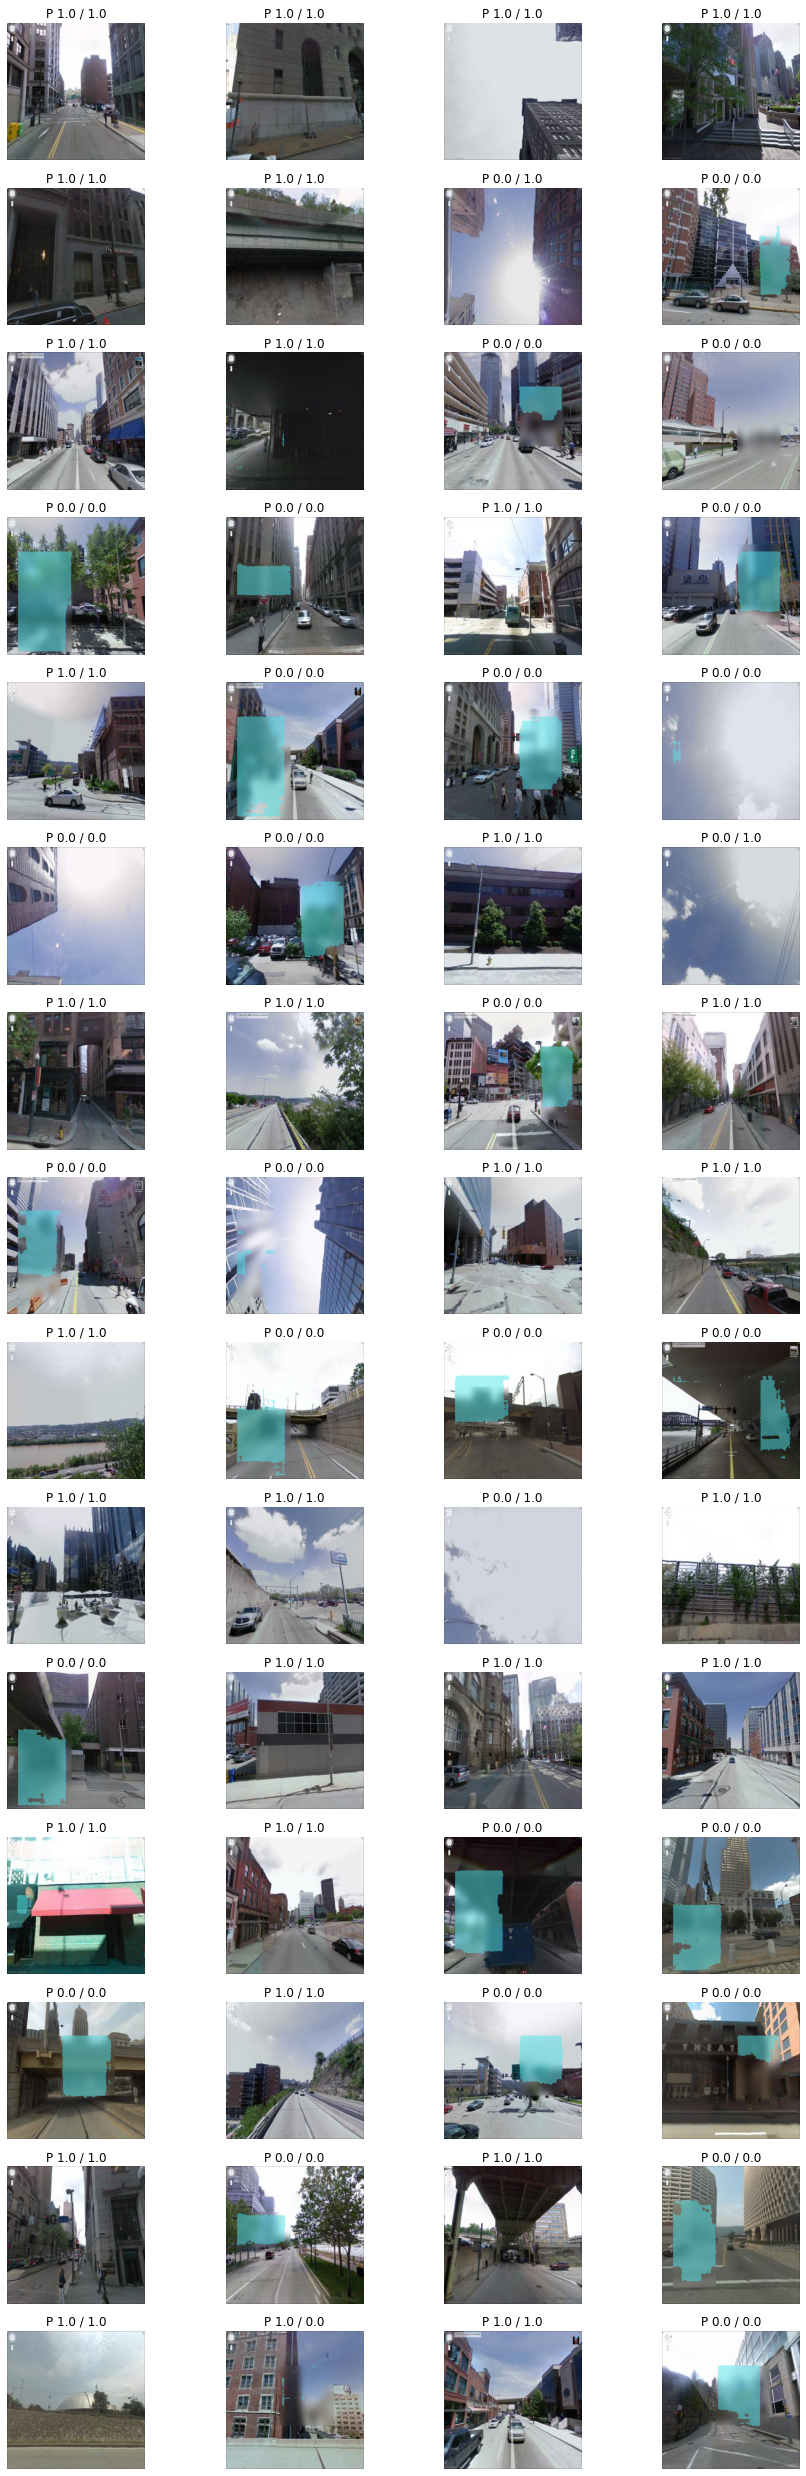

In [52]:
fig = plt.figure(figsize=(15,45))
columns = 4
rows = 15
print("predicted class vs true class")
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  img_pred_label = np.where((((predictions[i])[0])[0])>0.5,1.0,0.0)
  mask=(img_pred_label*255.0).astype(np.uint8)
  blackFrame = np.zeros((224,224, 3), dtype = "uint8")
  whiteFrame = 255 * np.ones((224,224,3), np.uint8)
  #label_img = Image.fromarray(label_img)
  mask = np.where(mask==255,whiteFrame,blackFrame)
  img= images[i]
  cyan = np.full_like(img,(80, 229, 235))
  blend = 0.5
  img_cyan = cv2.addWeighted(img, blend, cyan, 1-blend, 0)
  mask = np.where(mask>=165,img_cyan,img)
  #mask =cv2.cvtColor(mask , cv2.COLOR_BGR2RGB)
  plt.imshow(mask,cmap='binary')
  #mask = Image.fromarray(mask)
  predicted_class=y_pred_class[i]
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=12)
  plt.axis("off")
plt.show()

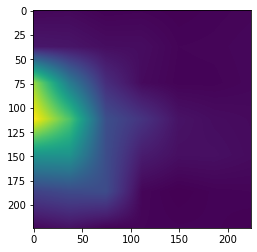

In [ ]:
plt.imshow(class_activation_map[1]*255.0)
#plt.imshow(label2rgb(class_activation_map[1],images[1]))

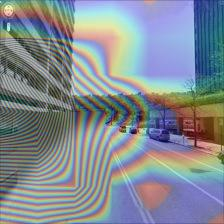

In [ ]:
import matplotlib.cm as cm
from IPython.display import Image, display
heatmap = np.uint8(255 * class_activation_map[1])
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((images[1].shape[1], images[1].shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
superimposed_img = jet_heatmap *0.4+ images[1]
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
superimposed_img.save('gg.jpg')
#plt.imshow(superimposed_img,cmap='binary')
display(Image('gg.jpg'))

In [ ]:
images[1].shape[1]

224

predicted class vs true class


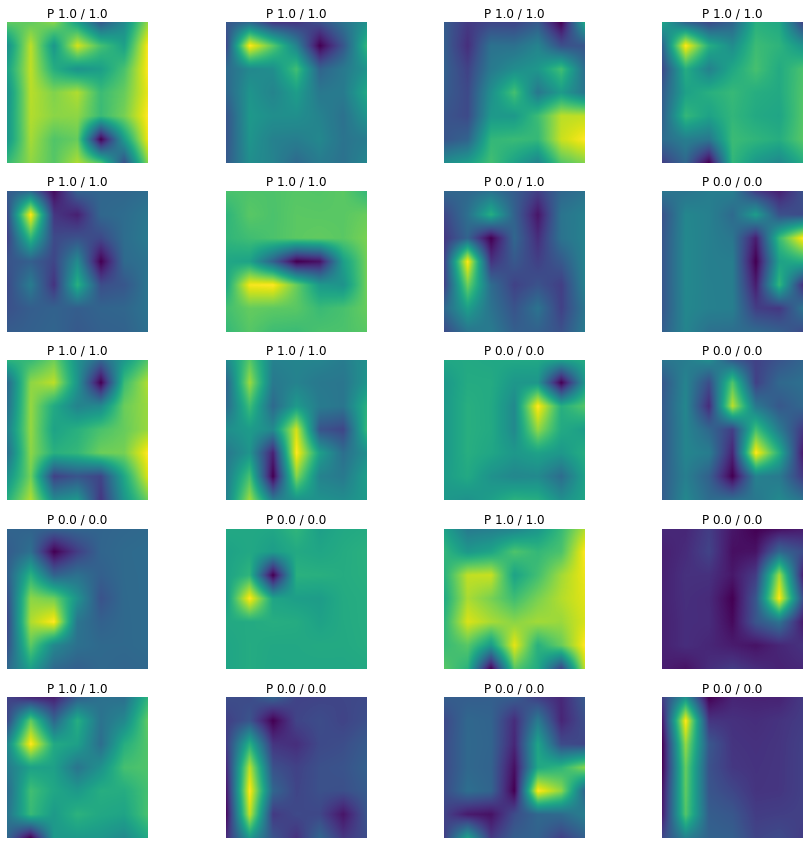

In [53]:
columns = 4
rows = 5
from skimage.color import label2rgb
print("predicted class vs true class")
fig = plt.figure(figsize=(15,15))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(class_activation_map[i])
  #plt.imshow(label2rgb(class_activation_map[i],images[i]))
  predicted_class=y_pred_class[i]
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=12)
  plt.axis("off")
plt.show()

predicted class vs true class


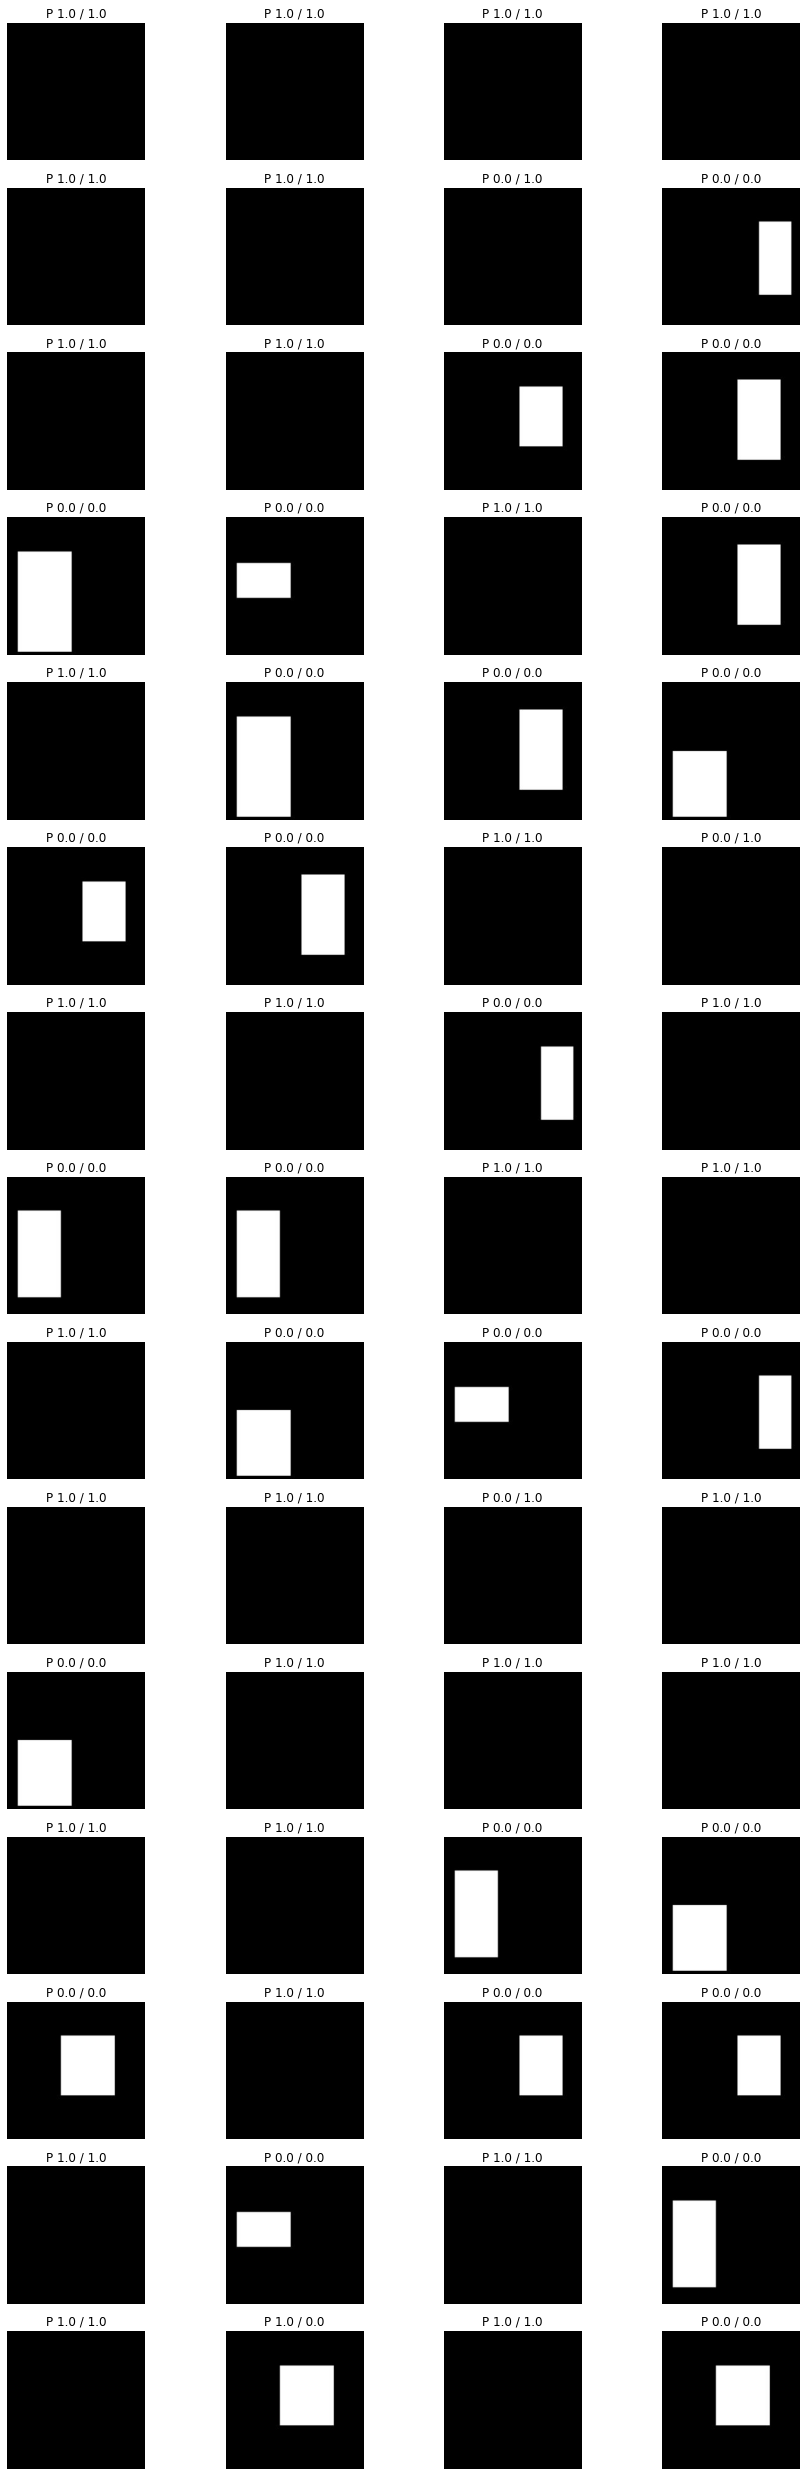

In [54]:
columns = 4
rows = 15
from skimage.color import label2rgb
print("predicted class vs true class")
fig = plt.figure(figsize=(15,45))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(eval_labels[i])
  predicted_class=y_pred_class[i]
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=12)
  plt.axis("off")
plt.show()

predicted class vs true class


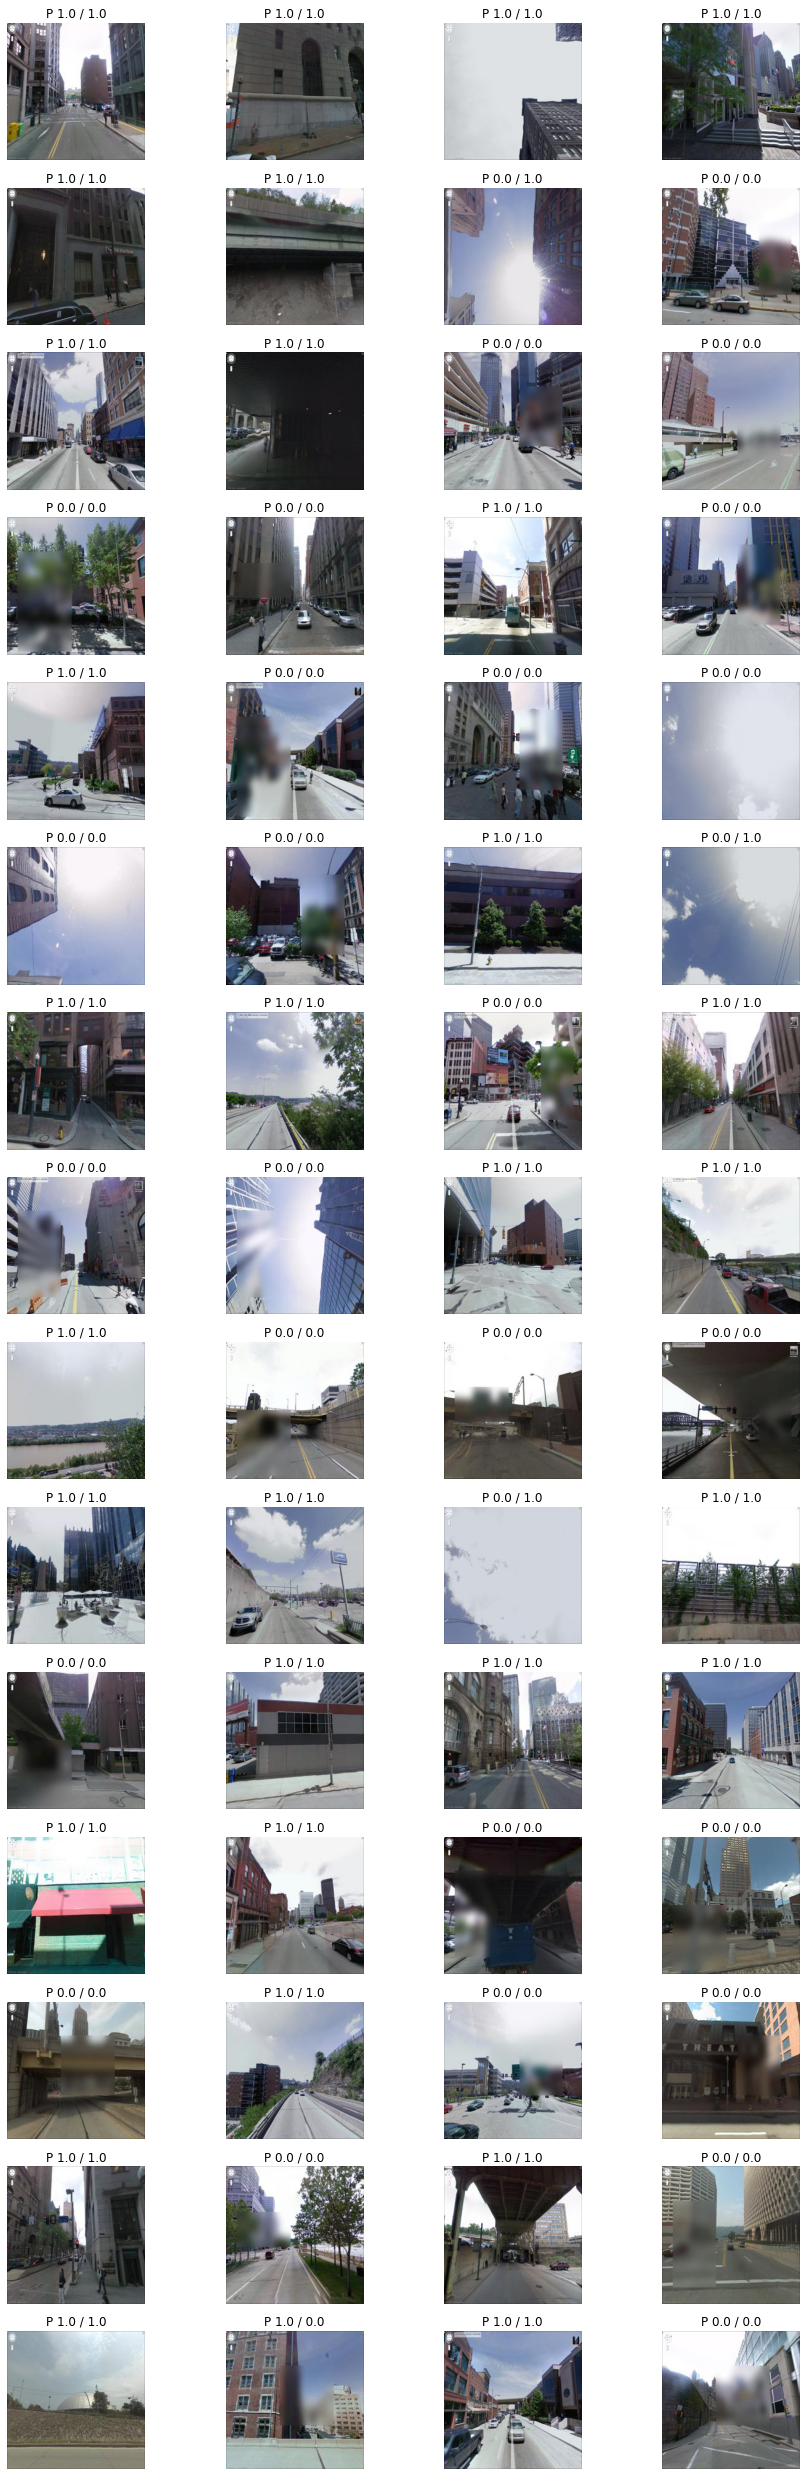

In [55]:
columns = 4
rows = 15
from skimage.color import label2rgb
print("predicted class vs true class")
fig = plt.figure(figsize=(15,45))
for i in range(0, columns*rows):
  fig.add_subplot(rows, columns,i+1)
  plt.imshow(images[i])
  predicted_class=y_pred_class[i]
  plt.title(f"P {predicted_class} / {eval_class_label[i]}",fontsize=12)
  plt.axis("off")
plt.show()